In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from functions import *

In [2]:
file = open("/xtmp/DC-BATS_data/binary_AR/full_mcmc.pkl", "rb")
trace_full = pickle.load(file)

In [3]:
m = 10
n_mcmc, p = np.shape(trace_full['alpha'])
q = np.shape(trace_full['b'])[1]

In [4]:
samples = np.zeros((m,n_mcmc,p+q+1))
mle = np.zeros((m,p+q+1))
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/binary_AR/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace_dc = pickle.load(file)
    samples[i,:,0:p] = trace_dc['alpha']
    samples[i,:,p:(p+q)] = trace_dc['b']
    samples[i,:,(p+q):(p+q+1)] = np.reshape(trace_dc['c'], [n_mcmc,1])
    
    file = open("/xtmp/DC-BATS_data/binary_AR/mle_chunk"+str(i+1)+".pkl", "rb")
    mle_dc = pickle.load(file)
    mle[i,0:p] = mle_dc['alpha']
    mle[i,p:(p+q)] = mle_dc['b']
    mle[i,(p+q):(p+q+1)] = mle_dc['c']

In [5]:
samples_combined = double_parallel_MC(samples, mle)
dpMC_CI = np.percentile(np.reshape(samples_combined, [np.prod(np.shape(samples_combined)[0:2]),np.shape(samples_combined)[-1]]), 
                        q=[2.5,97.5], axis=0)
alpha_ci_dpMC = dpMC_CI[:,0:p]
b_ci_dpMC = dpMC_CI[:,p:(p+q)]
c_ci_dpMC = dpMC_CI[:,(p+q):(p+q+1)]

100%|██████████| 5000/5000 [00:00<00:00, 23051.83it/s]


In [6]:
file = open("/xtmp/DC-BATS_data/binary_AR/full_mcmc.pkl", "rb")
trace = pickle.load(file)
c_ci_full = np.percentile(trace['c'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])

c_ci_dc = np.zeros(2)
alpha_ci_dc = np.zeros((2,p))
b_ci_dc = np.zeros((2,q))
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/binary_AR/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    c_ci_dc += np.percentile(trace['c'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m

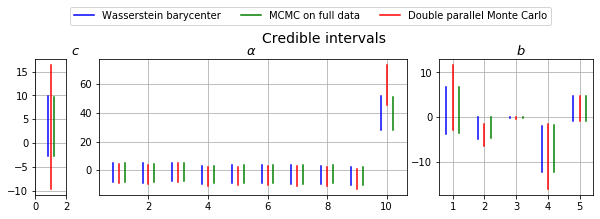

In [7]:
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, p, q]}, figsize=(10,2.5))

# a0.plot(1, c, "ro")
a0.plot([0.8,0.8], c_ci_dc, "b-")
a0.plot([1.2,1.2], c_ci_full, "g-")
a0.plot([1,1], c_ci_dpMC, "r-")
a0.axis(xmin=0,xmax=2)

# a1.plot(np.arange(1,p+1), alph, "ro")
for i in range(p) :
    a1.plot([i+0.8,i+0.8], alpha_ci_dc[:,i], "b-")
    a1.plot([i+1.2,i+1.2], alpha_ci_full[:,i], "g-")
    a1.plot([i+1,i+1], alpha_ci_dpMC[:,i], "r-")

# a2.plot(np.arange(1,q+1), b, "ro")
for i in range(q) :
    if i < (q-1) :
        a2.plot([i+0.8,i+0.8], b_ci_dc[:,i], "b-")
        a2.plot([i+1.2,i+1.2], b_ci_full[:,i], "g-")
        a2.plot([i+1,i+1], b_ci_dpMC[:,i], "r-")
    if i == (q-1) :
        a2.plot([i+0.8,i+0.8], b_ci_dc[:,i], "b-", label="Wasserstein barycenter")
        a2.plot([i+1.2,i+1.2], b_ci_full[:,i], "g-", label="MCMC on full data")
        a2.plot([i+1,i+1], b_ci_full[:,i], "r-", label="Double parallel Monte Carlo")
    
plt.text(x=-11, y=14, s=r"$c$", fontsize=13)
plt.text(x=-5.5, y=14, s=r"$\alpha$", fontsize=13)
plt.text(x=3, y=14, s=r"$b$", fontsize=13)
plt.text(x=-5, y=16.5, s=r"Credible intervals", fontsize=14)
plt.legend(ncol=3, loc=(-2.4,1.25))
f.savefig('binary_AR_CI.pdf', bbox_inches='tight', dpi=500)